## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imsave as mpsave
from matplotlib.image import imread as mpread
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix, and store it

In [ ]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump(
        {
            'mtx': mtx,
            'dist': dist,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload the previously loaded calibration result

In [2]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = mpread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration17.jpg


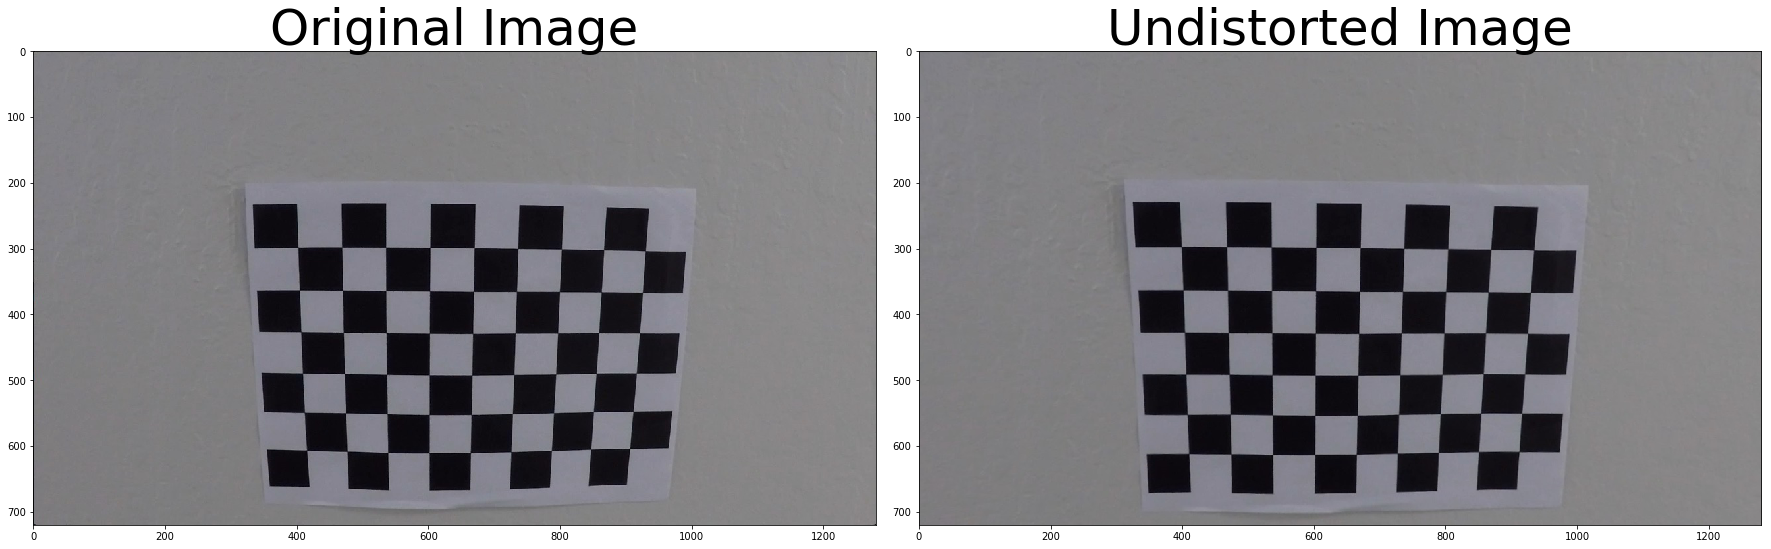

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = mpread(pers_img)
    plt.imshow(img)
    src = np.float32([[560, 460], [720, 460], [1250, 720], [40, 720]])
    dst = np.float32([[100, 0], [1060, 0], [1060, 700], [100, 700]])
        
    src = np.float32([[490, 482],[800, 482], [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1200, 720],[40, 720]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


### calculate perspective transformation info and save them in a pickle file

..\test_images\straight_lines1.jpg


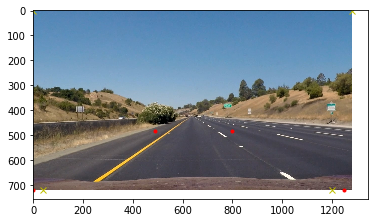

In [6]:
M, Minv = get_perspective_transform_mtx()

import pickle
with open('dump2.pkl', 'wb') as f:
    pickle.dump(
        {
            'M': M,
            'Minv': Minv,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload perspective transformation info from previously saved pickle file


In [7]:
import pickle
with open('dump2.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    M = pickle_data['M']
    Minv = pickle_data['Minv']

test and check the perspective transformation

In [8]:
import os
def testimg_perspective_transform(m, imgidx = 1):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines' + str(imgidx) + '.jpg')
    print(imgname)
    img = mpread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)


..\test_images\straight_lines1.jpg


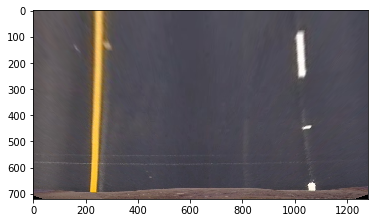

In [9]:
testimg_perspective_transform(M, imgidx = 1)   

..\test_images\straight_lines2.jpg


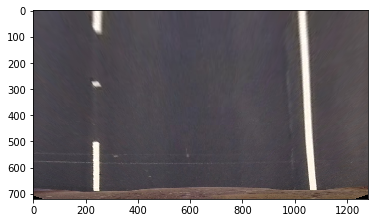

In [10]:
testimg_perspective_transform(M, imgidx = 2)  

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [11]:
from cv2 import Sobel
def build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = None, thresh = (170, 255)):
    if rawtype == 'rgb':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        rgb = img
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif rawtype == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        assert 0, 'rawtype should be bgr or rgb'
    
    channelname = channeltype.lower()
    if channelname ==  'gray':
        channel = gray
    elif channelname == 'rgb_r':
        channel = rgb[:,:,0]
    elif channelname == 'rgb_g':
        channel = rgb[:,:,1]
    elif channelname == 'rgb_b':
        channel = rgb[:,:,2]
    elif channelname == 'hls_h':
        channel = hls[:,:,0]
    elif channelname == 'hls_l':
        channel = hls[:,:,1]
    elif channelname == 'hls_s':
        channel = hls[:,:,2]
    elif channelname == 'luv_l':
        channel = luv[:, :, 0]
    elif channelname == 'luv_u':
        channel = luv[:, :, 1]
    elif channelname == 'luv_v':
        channel = luv[:, :, 2]
    elif channelname == 'lab_l':
        channel = lab[:, :, 0]
    elif channelname == 'lab_a':
        channel = lab[:, :, 1]
    elif channelname == 'lab_b':
        channel = lab[:,:,2]
    else:
        assert 0, 'channel name ' + channelname + ' not valid'
        
    if gradient != None:
        if gradient.lower() == 'x':
            newimg = Sobel(channel, cv2.CV_64F, 1, 0)
        else:
            newimg = Sobel(channel, cv2.CV_64F, 0, 1)
        newimg = np.absolute(newimg)
        newimg = np.int8(255 * newimg / np.max(newimg))
    else:
        newimg = channel
    
    result = np.zeros_like(newimg)
    avg1 = np.mean(np.mean(newimg))
    min1 = np.min(np.min(newimg))
    max1 = np.max(np.max(newimg))
    print('avg=', avg1, ' min=', min1, ' max=', max1)
    result[(newimg >= thresh[0]) & (newimg <= thresh[1])] = 1
    return result


def combine_imgs(bin_img1, bin_img2):
    assert bin_img1.shape == bin_img2.shape
    combined = np.zeros_like(bin_img1)
    combined[(bin_img1 > 0) | (bin_img2 > 0)] = 1
    return combined

def gray_img(bin_img):
    return bin_img * 255

def build_gray_img(color_img, rawtype, channeltype ):
    assert rawtype == 'rgb' or rawtype == 'bgr', 'raw type should be rgb or bgr'
    if  channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'bgr':
        if channeltype == 'rgb_r':
            return color_img[:,:,2]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,0]
    elif channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'rgb':
        if channeltype == 'rgb_r':
            return color_img[:,:,0]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,2]
    elif channeltype in ['hls_h', 'hls_l', 'hls_s']:
        if rawtype == 'bgr':
            img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
        elif rawtype == 'rgb':
            img = cv2.cvtColor(color_img, cv2.COLOR_RGB2HLS)
            
        if channeltype == 'hls_h':
            return img[:, :, 0]
        elif channeltype == 'hls_l':
            return img[:, :, 1]
        else:
            return img[:, :, 2]
    elif channeltype == 'gray':
        if rawtype == 'rgb':
            return cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        elif rawtype == 'bgr':
            return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
        
def bin_img(img, thresh):
    # img should has size 2
    result = np.zeros_like(img)
    result[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return result
    

### test build_binary_img function

In [12]:
import os
def testimg_build_binary(picidx = 6):
    
    imgname = os.path.join('..', 'test_images', 'test' + str(picidx)+'.jpg')
    print('testing the binary img build function on image: ', imgname)
    imgraw = mpread(imgname)
    
    img_undistort = cv2.undistort(imgraw, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img_undistort, M, (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
    
    print('gray img')
    img01 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', thresh = (210,255))
#     img02 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = 'x', thresh= (50, 100))
#     img03 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'gray')
    
#     img04 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', thresh = (200, 255))
#     img05 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', gradient = 'x', thresh= (40, 100))
#     img06 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_r')
    
#     img07 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g')
#     img08 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g', gradient = 'x', thresh= (20, 100))
#     img09 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_g')
    
#     img10 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', thresh = (155, 200))
#     img11 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', gradient = 'x', thresh= (20, 100))
#     img12 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_b')
    
#     img13 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h')
#     img14 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h', gradient = 'x', thresh= (20, 100))
#     img15 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_h')
    
#     img16 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', thresh = (200, 255))
#     img17 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', gradient = 'x', thresh= (20, 100))
#     img18 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_l')
    
#     img19 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', thresh = (180, 255))
#     img20 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', gradient = 'x', thresh= (20, 100))
#     img21 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_s')
    

    luv_l = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    avg1 = np.mean(np.mean(luv_l))
    max1 = np.max(np.max(luv_l))
    low = avg1 + (max1 - avg1)*3.0/4.0
    high = max1+1
    print('luv_l img, avg =', avg1, 'max =', max1, 'thresh=', low, high)
    img22 = bin_img(luv_l, (low, high))
    # img22 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'luv_l', thresh = (210, 255))   
    

    lab_b = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:,:,2]
    avg1 = np.mean(np.mean(lab_b))
    max1 = np.max(np.max(lab_b))
    low = avg1 + (max1 - avg1) *2.0/4.0
    high = max1+1
    print('lab_b img, avg = ', avg1, ' max = ', max1, 'thresh=', low, high)
    img23 = bin_img(lab_b, (low, high))
#     img23 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (155, 200))
#     img23, avg = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (100, 200))
    
    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
   
    
    ax[0][0].imshow(imgraw)
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow( img_undistort)
    ax[0][1].set_title('undistorted Image', fontsize=32)
    
    ax[0][2].imshow(img)
    ax[0][2].set_title('warp perspective img', fontsize=32)    


    ax[1][0].imshow(gray_img(img01), cmap = 'gray')
    ax[1][0].set_title('gray threshold img', fontsize = 32)
    
#     ax[1][1].imshow(gray_img(img02), cmap = 'gray')
#     ax[1][1].set_title('gray x sobel threshold img', fontsize = 32)
    
#     ax[1][1].imshow(gray_img(img03), cmap = 'gray')
#     ax[1][1].set_title('gray img', fontsize = 32)

    
#     ax[2][0].imshow(gray_img(img04), cmap = 'gray')
#     ax[2][0].set_title('r threshold img', fontsize = 32)
    
#     ax[2][1].imshow(gray_img(img05), cmap = 'gray')
#     ax[2][1].set_title('r x sobel threshold img', fontsize = 32)
    
#     ax[2][2].imshow(img06, cmap = 'gray')
#     ax[2][2].set_title('r img', fontsize = 32)
    
    
#     ax[3][0].imshow(gray_img(img07), cmap = 'gray')
#     ax[3][0].set_title('g threshold img', fontsize = 32)

#     ax[3][1].imshow(gray_img(img08), cmap = 'gray')
#     ax[3][1].set_title('g x sobel threshold img', fontsize = 32)
    
#     ax[3][2].imshow(img09, cmap = 'gray')
#     ax[3][2].set_title('g  img', fontsize = 32)
    
    
#     ax[4][0].imshow(gray_img(img10), cmap = 'gray')
#     ax[4][0].set_title('b threshold img', fontsize = 32)
    
#     ax[4][1].imshow(gray_img(img11), cmap = 'gray')
#     ax[4][1].set_title('b x sobel threshold img', fontsize = 32)
    
#     ax[4][2].imshow(img12, cmap = 'gray')
#     ax[4][2].set_title('b  img', fontsize = 32)
    
    
#     ax[5][0].imshow(gray_img(img13), cmap = 'gray')
#     ax[5][0].set_title('h threshold img', fontsize = 32)
    
#     ax[5][1].imshow(gray_img(img14), cmap = 'gray')
#     ax[5][1].set_title('h x sobel threshold img', fontsize = 32)
    
#     ax[5][2].imshow(img15, cmap = 'gray')
#     ax[5][2].set_title('h  img', fontsize = 32)
    
    
#     ax[6][0].imshow(gray_img(img16), cmap = 'gray')
#     ax[6][0].set_title('l threshold img', fontsize = 32)
    
#     ax[6][1].imshow(gray_img(img17), cmap = 'gray')
#     ax[6][1].set_title('l x sobel threshold img', fontsize = 32)
    
#     ax[6][2].imshow(img18, cmap = 'gray')
#     ax[6][2].set_title('l img', fontsize = 32)
    
    
#     ax[7][0].imshow(gray_img(img19), cmap = 'gray')
#     ax[7][0].set_title('s threshold img', fontsize = 32)
    
#     ax[7][1].imshow(gray_img(img20), cmap = 'gray')
#     ax[7][1].set_title('s x sobel threshold img', fontsize = 32)
    
#     ax[7][2].imshow(img21, cmap = 'gray')
#     ax[7][2].set_title('s  img', fontsize = 32)
    
    
    ax[1][1].imshow(gray_img(img22), cmap = 'gray')
    ax[1][1].set_title('luv l channel threshold img', fontsize = 32)
    
    ax[1][2].imshow(gray_img(img23), cmap = 'gray')
    ax[1][2].set_title('lab b channel threshold img', fontsize = 32)
    
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # return the raw input img, the img after undistortion and perspective transformation
    return imgraw, img

testing the binary img build function on image:  ..\test_images\test6.jpg
gray img
avg= 85.0427625868  min= 0  max= 255
luv_l img, avg = 90.0143142361 max = 255 thresh= 213.753578559 256
lab_b img, avg =  129.445677083  max =  212 thresh= 170.722838542 213
testing the binary img build function on image:  ..\test_images\test12.jpg
gray img
avg= 135.714084201  min= 0  max= 218
luv_l img, avg = 142.922943793 max = 221 thresh= 201.480735948 222
lab_b img, avg =  129.478696832  max =  181 thresh= 155.239348416 182
testing the binary img build function on image:  ..\test_images\test13.jpg
gray img
avg= 40.1753862847  min= 0  max= 213
luv_l img, avg = 43.7356738281 max = 218 thresh= 174.433918457 219
lab_b img, avg =  119.705713976  max =  133 thresh= 126.352856988 134


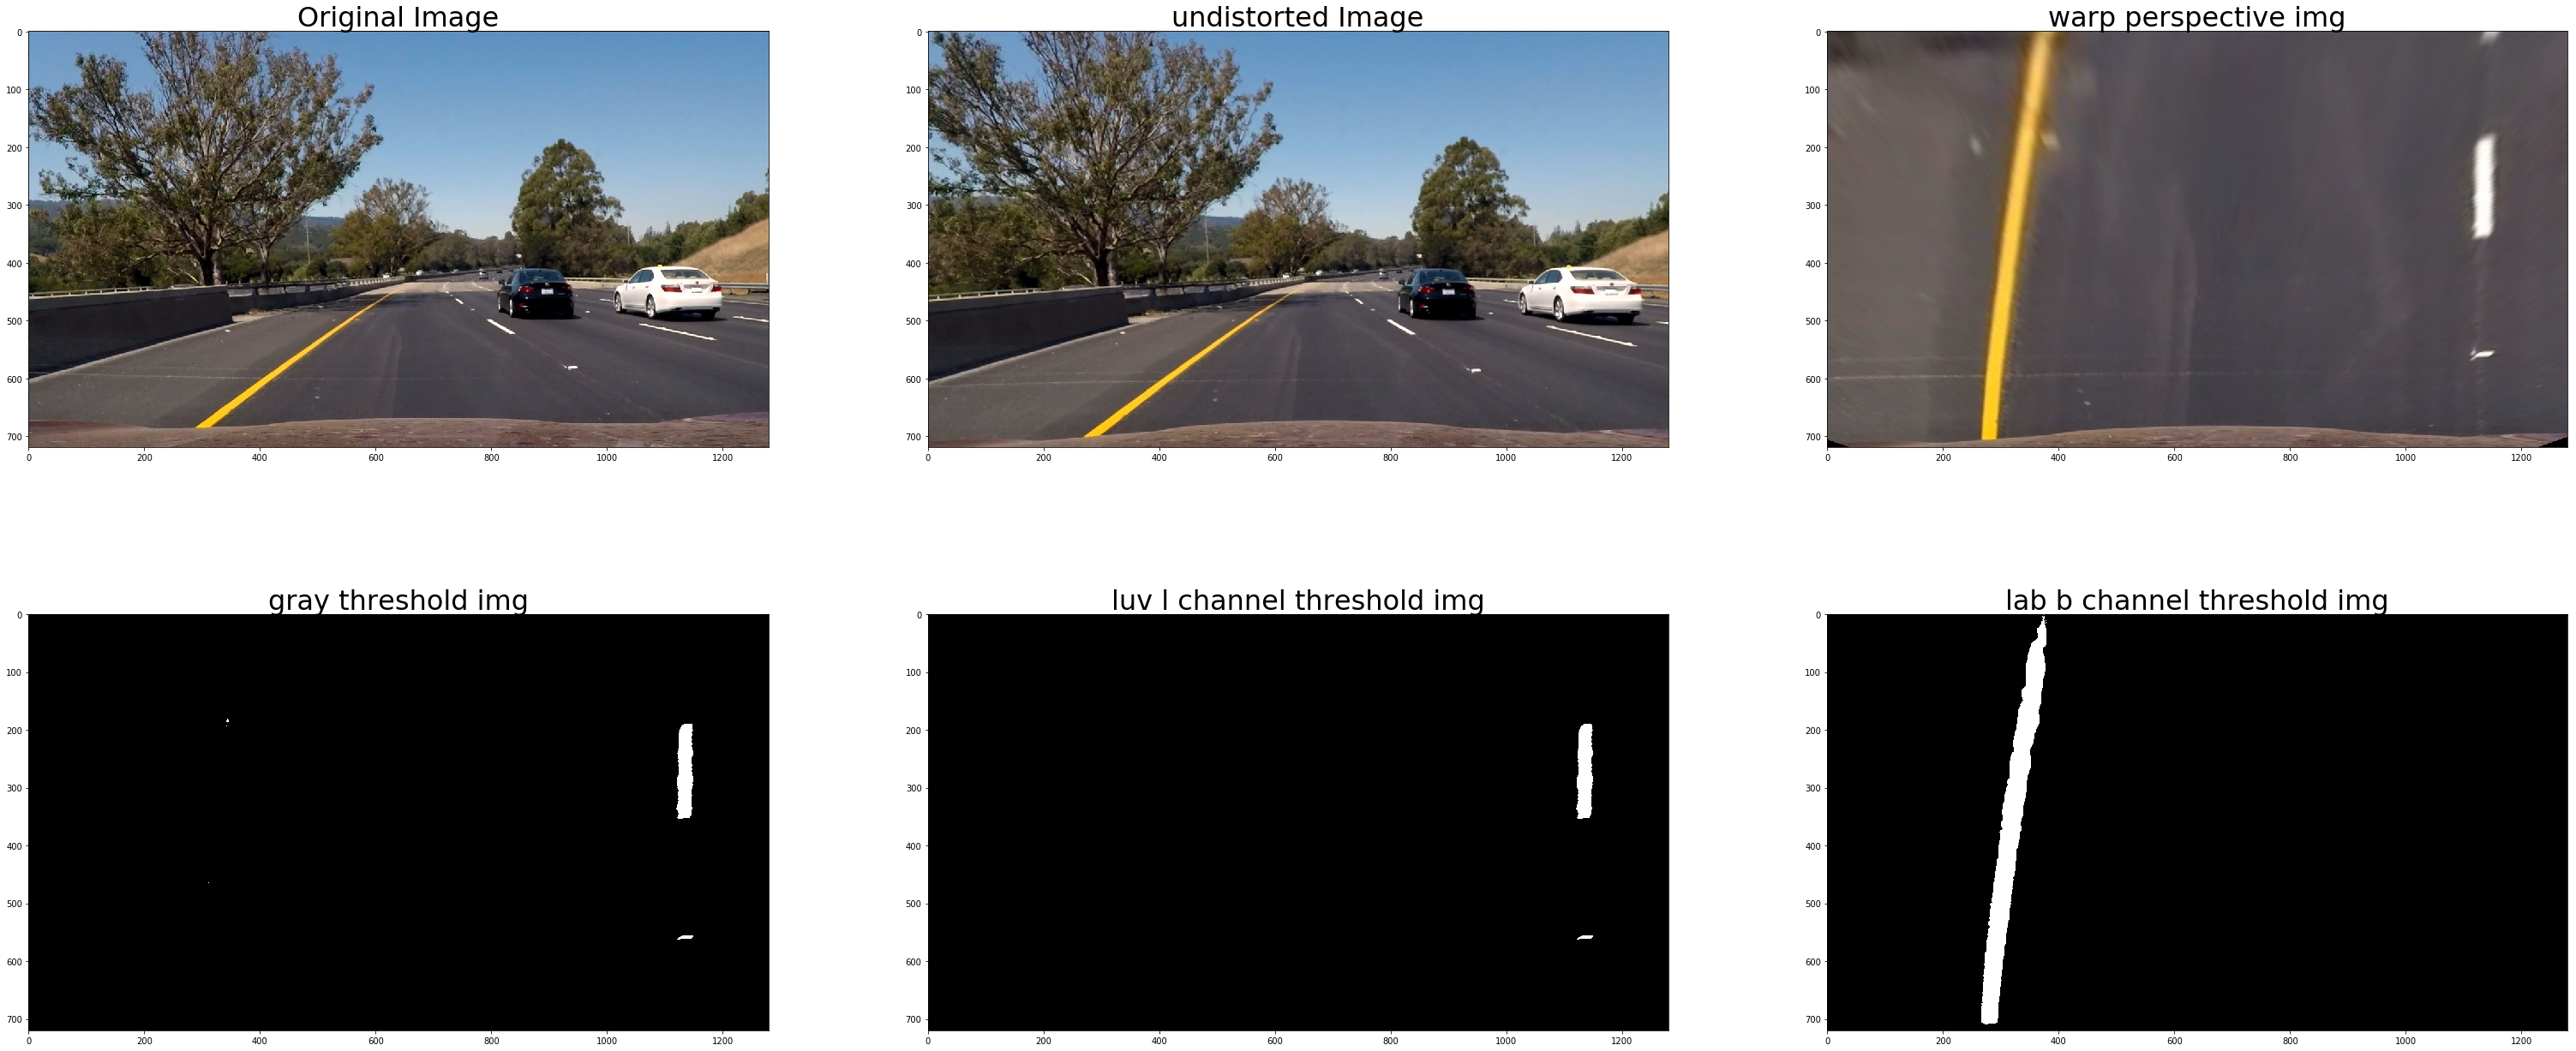

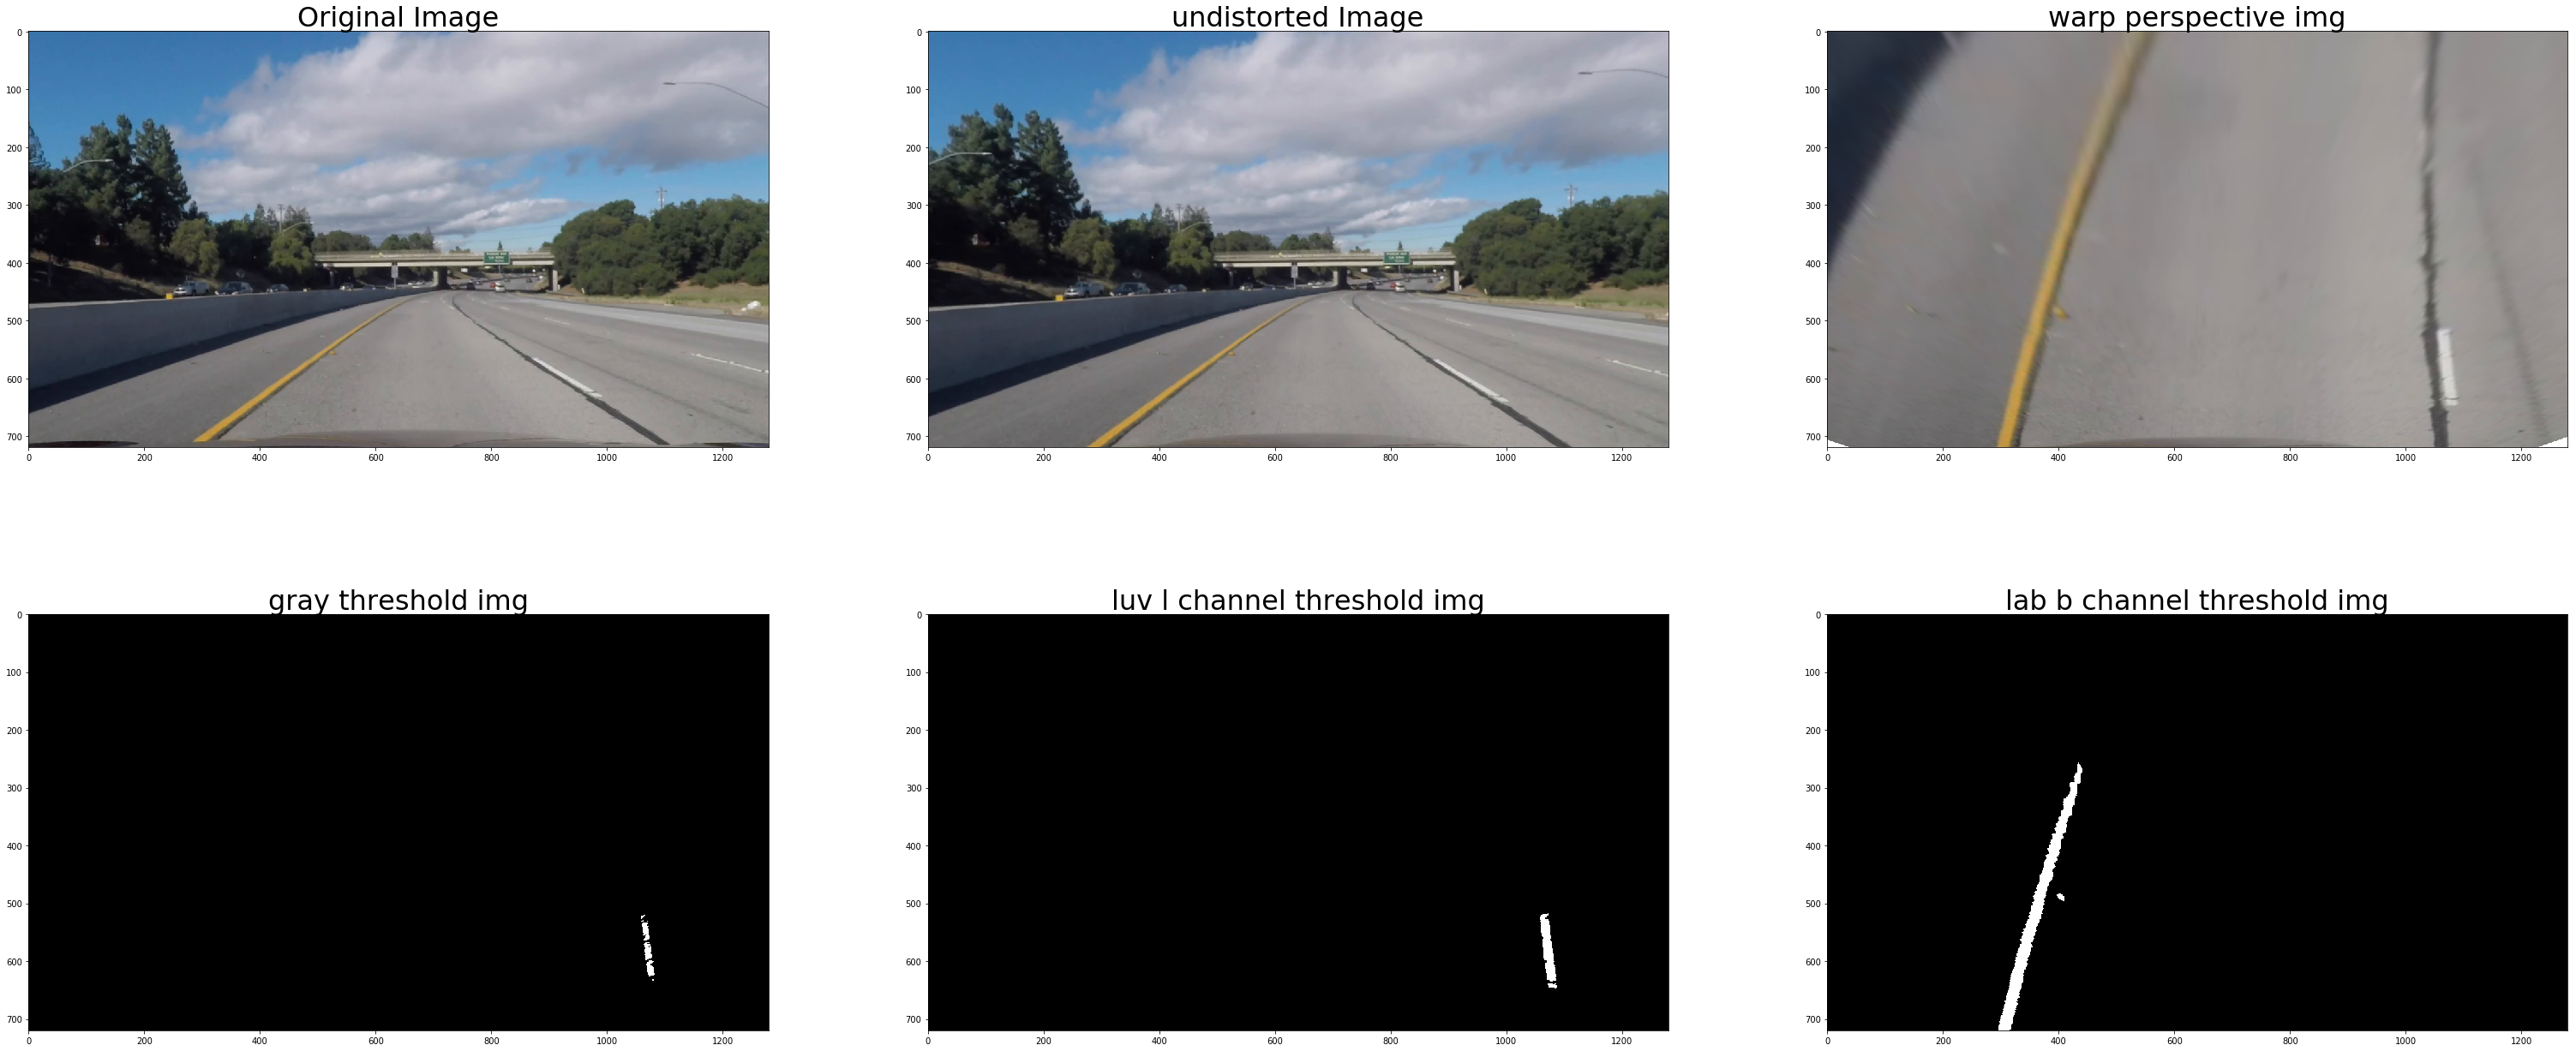

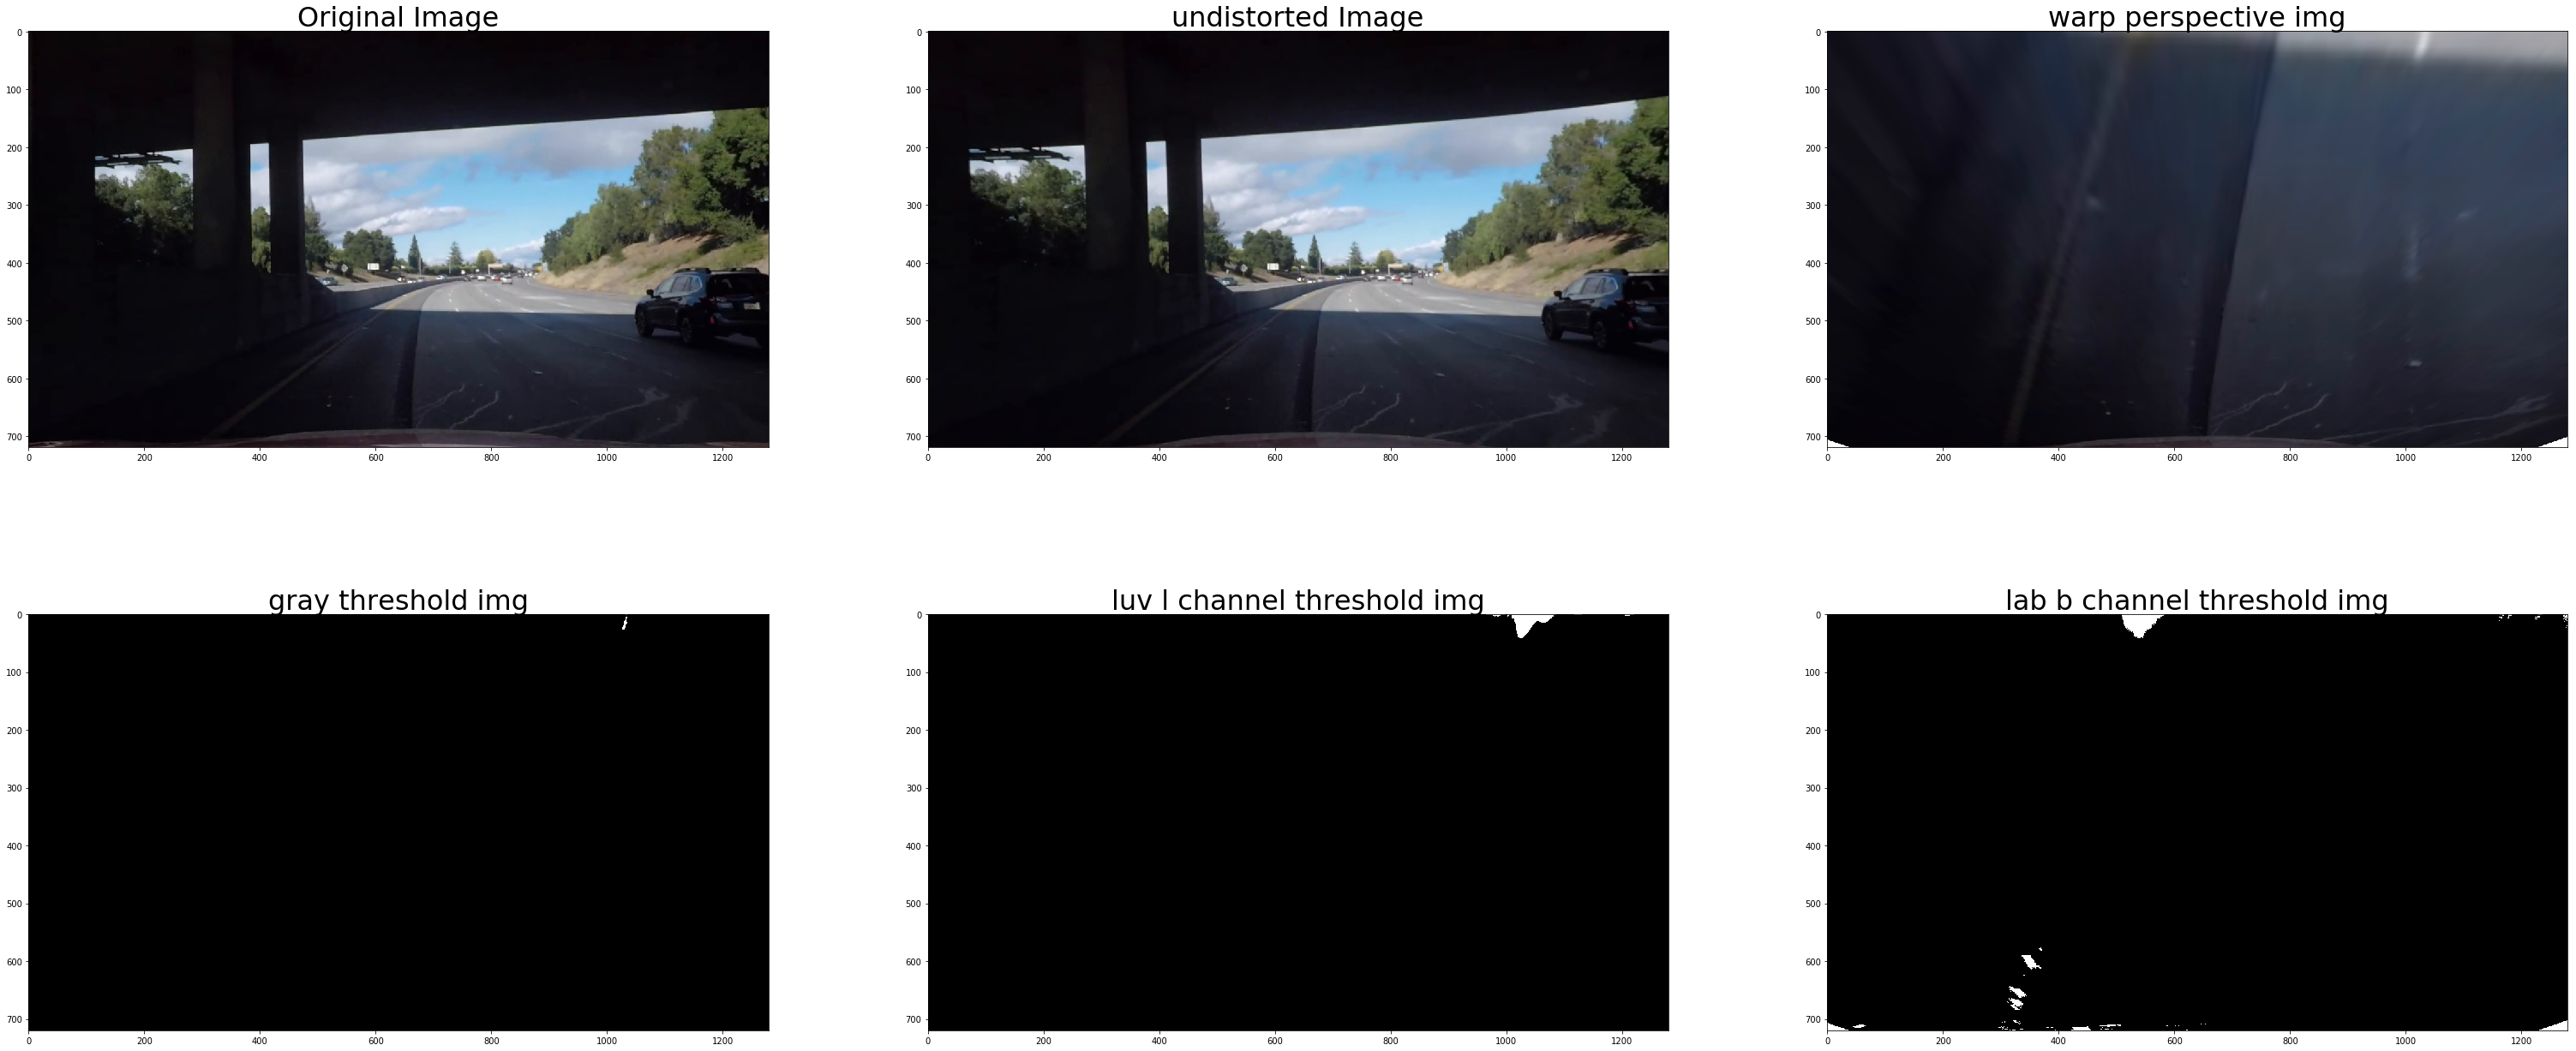

In [13]:
# img_raw1, img_basic1 = testimg_build_binary(picidx = 1)
# img_raw2, img_basic2 = testimg_build_binary(picidx = 2)
# img_raw3, img_basic3 = testimg_build_binary(picidx = 3)
# img_raw4, img_basic4 = testimg_build_binary(picidx = 4)
# img_raw5, img_basic5 = testimg_build_binary(picidx = 5)
img_raw6, img_basic6 = testimg_build_binary(picidx = 6)
# img_raw7, img_basic7 = testimg_build_binary(picidx = 7)
# img_raw8, img_basic8 = testimg_build_binary(picidx = 8)
# img_raw9, img_basic9 = testimg_build_binary(picidx = 9)
# img_raw10, img_basic10 = testimg_build_binary(picidx = 10)
# img_raw11, img_basic11 = testimg_build_binary(picidx = 11)
img_raw12, img_basic12 = testimg_build_binary(picidx = 12)
img_raw13, img_basic13 = testimg_build_binary(picidx = 13)

In [14]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    # but actually when we detect the base lane x-position, we had better consider the bottom half as the lan maybe curving
    histogram = np.sum( img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))   
    return histogram

In [15]:
# img_basic is the combined binary image we will do lane finding

# histogram = get_histogram(img_basic1)
# histogram = get_histogram(img_basic2)
# histogram = get_histogram(img_basic3)
# histogram = get_histogram(img_basic4)
# histogram = get_histogram(img_basic5)
histogram = get_histogram(img_basic6)

### using the binary image to get the xm_per_pix and ym_per_pix


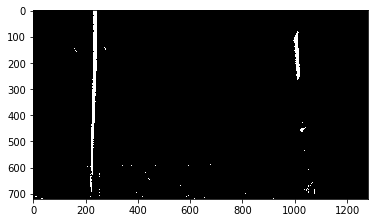

In [16]:
import os
def get_xm_per_pix():
    # we use a straight line img, e.g., test_imgs/straignt_lines1.jpg for calc
    # 1. do un-distortion
    # 2. perspective change
    # 3. get the left and right lane distance by pixel
    # 4. comparing with the real value, we assume 3.5m, 
    # return the xm_per_pix
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = mpread(imgname)
    img_size = img.shape[1], img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    color_thresh = (170, 255)
    sobel_thresh = (20, 100)
    
    sobelx = Sobel(gray, cv2.CV_64F, 1, 0)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobel_bin = np.zeros_like(sobelx)
    sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 255

    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    plt.imshow(sobel_bin, cmap = 'gray')
    hist = get_histogram(sobel_bin)
    
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    lane_line_pixel = rightx_base - leftx_base
    lane_line_meter = 3.7
    xm_per_pixel = lane_line_meter / lane_line_pixel
    return xm_per_pixel
xm_per_pixel = get_xm_per_pix()        

Sliding Window

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

# pipe line for video

In [17]:
def get_threshold_bin_img(img):
    # for video pipeline, the readin img is RGB format
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    b_avg = np.mean(np.mean(b_channel))
    b_max = np.max(np.max(b_channel))
    b_thresh_min = 145
    b_thresh_max = 200
#     b_thresh_min = b_avg + (b_max - b_avg)*3.0/4.0
#     b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    l_avg = np.mean(np.mean(l_channel))
    l_max = np.max(np.max(l_channel))
    l_thresh_min = 215
    l_thresh_max = 255
#     l_thresh_min = l_avg + (l_max- l_avg)*3.0/4.0
#     l_thresh_max = l_max
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    gray_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_thresh_min = 210
    gray_thresh_max = 255
    gray_binary = np.zeros_like(gray_channel)
    gray_binary[(gray_channel >= gray_thresh_min) & (gray_channel <= gray_thresh_max)] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (gray_binary == 1)] = 1
    return combined_binary

In [18]:
def blind_search(img, nwins, left_right):
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = int(xsize/2)
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    winblock_cnt = 0
    for win in range(nwins):
        # loop from img top to bottom
        histogram = np.sum(img[win * height: (win+1)*height, :], axis = 0)
        if left_right == 'left':
            peak = np.argmax(histogram[:xmid])
        else:
            peak = np.argmax(histogram[xmid:]) + xmid

        x_idx = np.where((((peak - 25) < x) & 
                          (x < (peak + 25)) &
                          ((y > win*height) & (y < (win+1)* height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            xvals.extend(x_window)
            yvals.extend(y_window)
            winblock_cnt += 1
    return xvals, yvals, winblock_cnt

In [19]:
def based_on_previous_search(img, prev_fittings,nwins):
    # here prev_fittings[0], prev_fittings[1], prev_fittings[2] store previous fitting frame img value
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = xsize/2
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    winblock_cnt = 0
    for win in range(nwins):
        #loop from top to down
        ymid = np.mean([win * height, (win +1) * height])

        xmid = (np.mean(prev_fittings[0]))*ymid**2 +(np.mean(prev_fittings[1]))*ymid + (np.mean(prev_fittings[2]))
        x_idx = np.where((((xmid - 25) < x) & (x < (xmid + 25))&((y > win*height) & (y < (win+1) * height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            np.append(xvals, x_window)
            np.append(yvals, y_window)
            winblock_cnt += 1
    return xvals, yvals, winblock_cnt

In [20]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img_basic6.shape[:2]
print(imgsize)

# the difference between LaneLineHandler2 and laneLineHandler is 
# LaneLineHander2 use the previous img left_x_base as the starting point for windows sliding
# while LaneLineHandler use histogram to detect the starting point
class LaneLineHandler2(object):
    def __init__(self, saved_dir = None):
        self.nwindows = 8
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 50
        # self.minpix = 50
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
    
        self.mtx = mtx
        self.dist = dist
        
        self.left_reuse_count = 0
        self.right_reuse_count = 0
        
        self.saved_dir = saved_dir
        self.img_count = 0
        self.nodata = False
        
        # for senalty check
        self.last_offset = None
        self.last_left_curvature_meter = None
        self.last_right_curvature_meter = None
        self.last_left_slope = []
        self.last_right_slope = []
        
        self.last_left_fittings = [[], [], [] ]
        self.last_right_fittings = [[], [], []]
        
        self.last_left_fittings_meter = [[], [], [] ]
        self.last_right_fittings_meter = [[], [], []]
        
    def run(self, img):
        self.readin(img)
        self.finding_pixels()
        self.fitting()
        result = self.drawBack()
        return result

        
    def readin(self, img, rawtype = 'rgb'):
        print('read in the img index:', self.img_count)
        # readin the raw color image taken from the camera
        self.img_count += 1
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        self.img_raw = img
        self.nodata = False
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
        
        self.img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        self.img_basic = get_threshold_bin_img(self.img_warped)
        x, y = np.nonzero(np.transpose(self.img_basic))
        if len(x) == 0:
            print('no data for fitting, using previous img')
            self.nodata = True
        return

    
    def finding_pixels(self):
        # we use different strategy to do searching
        if self.nodata == True:
            print('no data')
            self.leftx, self.lefty, self.rightx, self.righty = [], [], [], []
            self.left_nodata = True
            self.right_nodata = True
        else:
            self.left_nodata = False
            self.right_nodata = False
            left_block = 0
            right_block = 0
            if self.left_reuse_count >= 4 or self.img_count <= 1:
                self.leftx, self.lefty, left_block = blind_search(self.img_basic, self.nwindows, 'left')
                print('left blind search')
            else:
                self.leftx, self.lefty, left_block = based_on_previous_search(self.img_basic, self.last_left_fittings, self.nwindows)
                print('left based previous search')
                if len(self.leftx) == 0 or len(self.rightx) == 0:
                    self.leftx, self.lefty, left_block = blind_search(self.img_basic, self.nwindows, 'left')
            
            if self.right_reuse_count >= 4 or self.img_count <= 1:
                self.rightx, self.righty, right_block = blind_search(self.img_basic, self.nwindows, 'right')
            else:
                self.rightx, self.righty, right_block = based_on_previous_search(self.img_basic, self.last_right_fittings, self.nwindows)
                if len(self.rightx) == 0:
                    self.rightx, self.righty, right_block = blind_search(self.img_basic, self.nwindows, 'right')
            
            if left_block <= 1:
                self.left_nodata = True
            if right_block <= 1:
                self.right_nodata = True
#             if len(self.leftx) == 0:
#                 self.left_nodata = True
#             if len(self.rightx) == 0:
#                 self.right_nodata = True
            
            
            
    def senaltyCheck(self):
        # we handle left and right separately
        left_reuse, right_reuse = False, False
        
        # check if need to reuse left
        if self.left_reuse_count >= 20:
            left_reuse = False
        elif self.img_count <= 1:
            left_reuse = False
        else:
            if self.left_nodata == True:
                print('left lane no data, reuse previous left lane line')
                left_reuse = True
            elif self.left_pos > 600 or self.left_pos < 0:
                print('left_pos=', self.left_pos, ' not reasonable, reuse previous left_pos = ', self.last_left_pos)
            elif self.last_left_pos != None and abs(self.last_left_pos - self.left_pos) > 50:
                print('left lane = ', self.left_pos, ' switched too much, reuse previous left lane line= ', self.last_left_pos)
                left_reuse = True
            # elif self.last_left_curvature_meter != None and abs(self.last_left_curvature_meter - self.left_curvature_meter) > 4000:
            #    print('left curvature meter changed too much, reuse previous left lane line')
            #    left_reuse = True
            elif self.left_fit[2] > 1280 or self.left_fit[2] < 0:
                print('left lane top pos not good = ', self.left_fit[2])
                left_resue = True
        
        
        # check if need to reuse right
        if self.right_reuse_count >= 20:
            right_reuse = False
        elif self.img_count <= 1:
            right_reuse = False
        else:
            if self.right_nodata == True:
                print('right lane no data, reuse previous right lane line')
                right_reuse = True
            elif self.right_pos > 1280 or self.right_pos < 680:
                print('right lane = ', self.right_pos, ' not reasonable, reuse previous right pos =', self.last_right_pos)
            elif self.last_right_pos != None and abs(self.last_right_pos - self.right_pos) > 50:
                print('right lane =', self.right_pos, 
                      'switched too much, reuse previous right lane line = ', self.last_right_pos)
                right_reuse = True
#             elif self.last_right_curvature_meter != None and abs(self.last_right_curvature_meter - self.right_curvature_meter) > 4000:
#                 print('right curvature meter changed too much, reuse previous left lane line')
#                 right_reuse = True
            elif self.right_fit[2] > 1280 or self.right_fit[2] < 0:
                print('right lane top pos not good = ', self.right_fit[2])
                right_reuse = True
        
                
                
        if left_reuse == True:
            self.left_reuse_count += 1
            self.offset = self.last_offset
            self.left_pos = self.last_left_pos 
            self.left_curvature_meter = self.last_left_curvature_meter
            assert len(self.last_left_fittings[0]) >= 1
            self.left_fit = [ self.last_left_fittings[0][-1],
                            self.last_left_fittings[1][-1],
                            self.last_left_fittings[2][-1]]
            
            self.left_fit_meter = [ self.last_left_fittings_meter[0][-1],
                                   self.last_left_fittings_meter[1][-1],
                                   self.last_left_fittings_meter[2][-1]]
        else:
            self.left_reuse_count = 0
            self.last_offset = self.offset
            self.last_left_curvature_meter = self.left_curvature_meter
            self.last_leftx = self.leftx
            self.last_lefty = self.lefty
            self.last_left_pos = self.left_pos
            for i in range(3):
                self.last_left_fittings[i].append(self.left_fit[i])
                if len(self.last_left_fittings[i]) > 5:
                    self.last_left_fittings[i] = self.last_left_fittings[i][-5:]
                
                self.last_left_fittings_meter[i].append(self.left_fit_meter[i])
                if len(self.last_left_fittings_meter[i]) > 5:
                    self.last_left_fittings_meter[i] = self.last_left_fittings_meter[i][-5:]
                    
        if right_reuse == True:
            self.right_reuse_count += 1
            self.offset = self.last_offset
            self.right_pos = self.last_right_pos
            self.right_curvature_meter = self.last_right_curvature_meter
            assert len(self.last_right_fittings[0]) >= 1
            self.right_fit = [ self.last_right_fittings[0][-1],
                            self.last_right_fittings[1][-1],
                            self.last_right_fittings[2][-1]]
            
            self.right_fit_meter = [ self.last_right_fittings_meter[0][-1],
                                   self.last_right_fittings_meter[1][-1],
                                   self.last_right_fittings_meter[2][-1]]
        else:
            self.right_reuse_count = 0
            self.last_offset = self.offset
            self.last_right_curvature_meter = self.right_curvature_meter
            self.last_rightx = self.rightx
            self.last_righty = self.righty
            self.last_right_pos = self.right_pos
            for i in range(3):
                self.last_right_fittings[i].append(self.right_fit[i])
                if len(self.last_right_fittings[i]) > 5:
                    self.last_right_fittings[i] = self.last_right_fittings[i][-5:]
                
                self.last_right_fittings_meter[i].append(self.right_fit_meter[i])
                if len(self.last_right_fittings_meter[i]) > 5:
                    self.last_right_fittings_meter[i] = self.last_right_fittings_meter[i][-5:]
        
    def fitting(self):
        # no data for current, then do re-use previous frame img pixels
        if len(self.leftx) == 0:
            self.leftx = self.last_leftx
            self.lefty = self.last_lefty
        if len(self.rightx) == 0:
            self.rightx = self.last_rightx
            self.righty = self.last_righty
                
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        # self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        # self.right_fit_meter = np.polyfit(self.righty * self.ym_per_pix, self.rightx * self.xm_per_pix, 2)
        self.left_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.lefty],[x* self.xm_per_pix for x in self.leftx], 2)
        self.right_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.righty], [x*self.xm_per_pix for x in self.rightx], 2)
        
    
    def calcOffset(self):
        car_left = self.left_fit[0]*720**2 + self.left_fit[1]*720 + self.left_fit[2]
        car_right = self.right_fit[0]*720**2 + self.right_fit[1]*720 + self.right_fit[2]
        car_center = (car_left + car_right) /2.0
        self.left_pos = car_left
        self.right_pos = car_right
        # on a general check, the lane top should be in the range of [-20, 1230]
        self.offset = (car_center - 640)* self.xm_per_pix
        
    def calcCurvature(self):
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|


        self.left_curvature = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curvature= ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        
        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        
        self.left_curvature = ((1 + (2*left_fitting0*y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature= ((1 + (2*right_fitting0*y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
        y_eval = y_eval * self.ym_per_pix
        self.left_curvature_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curvature_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        
        left_fitting0 = np.mean(self.last_left_fittings_meter[0])
        left_fitting1 = np.mean(self.last_left_fittings_meter[1])
        left_fitting2 = np.mean(self.last_left_fittings_meter[2])
        right_fitting0 = np.mean(self.last_right_fittings_meter[0])
        right_fitting1 = np.mean(self.last_right_fittings_meter[1])
        right_fitting2 = np.mean(self.last_right_fittings_meter[2])
        
        self.left_curvature_meter =((1 + (2*left_fitting0* y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature_meter = ((1 + (2*right_fitting0 * y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
    
    def drawBack(self):
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
            

        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.img_raw).astype(np.uint8)
        
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )
        
        self.calcOffset()
        self.calcCurvature()
        self.senaltyCheck()

        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        left_fitx = left_fitting0*ploty**2 + left_fitting1*ploty + left_fitting2
        
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        right_fitx = right_fitting0 * ploty**2 + right_fitting1*ploty + right_fitting2


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img_basic.shape[1], self.img_basic.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.img_raw, 1, newwarp, 0.3, 0)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
                
        text = 'Curvature Radius: '+ '{0:.1f}'.format(self.left_curvature_meter/2.0 + self.right_curvature_meter/2.0 ) + ' m'
        cv2.putText(result, text, (50,100), font, 1.5, (255,255,255),2, cv2.LINE_AA)

    
        if self.offset > 0:
            text = 'Vehicle is ' + '{0:.2f}'.format(self.offset) + ' m left of center'
        else:
            text = 'Vehicle is ' + '{0:.2f}'.format(- self.offset) + ' m right of center' 
        cv2.putText(result, text, (50,200), font, 1.5, (255,255,255),2, cv2.LINE_AA)
        
        if self.left_reuse_count == 0:
            text = 'left lane recalc'
        else:
            text = 'reuse left lane= ' + str(self.left_reuse_count)
        if self.right_reuse_count == 0:
            text += '/right lane recalc'
        else:
            text += '/reuse right lane = '+ str(self.right_reuse_count)
            
        cv2.putText(result, text, (50, 300), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_1warped.jpg'
            cv2.imwrite(filename, self.img_warped)
            filename = self.saved_dir + str(self.img_count) + '_2basic.jpg'
            cv2.imwrite(filename, self.img_basic*255)
            filename = self.saved_dir + str(self.img_count) + '_3result.jpg'
            cv2.imwrite(filename, result)
            
        return result

(720, 1280)


In [21]:
g_handler2 = LaneLineHandler2()
def get_handler2():
    return g_handler2

In [22]:
def process_image2(img):
    handler = get_handler2()
    result = handler.run(img)
    return result

In [23]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# g_handler2 = LaneLineHandler2('../videoimg_project/')
g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip(video_input)
clip1 = VideoFileClip(video_input).subclip(0,2)
# clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image2)
%time challenge_clip.write_videofile(video_output, audio=False)

read in the img index: 0
left blind search
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

read in the img index: 1
left based previous search


  2%|█▋                                                                                 | 1/51 [00:00<00:18,  2.63it/s]

read in the img index: 2
left based previous search


  4%|███▎                                                                               | 2/51 [00:00<00:18,  2.72it/s]

read in the img index: 3
left based previous search


  6%|████▉                                                                              | 3/51 [00:01<00:17,  2.75it/s]

read in the img index: 4
left based previous search


  8%|██████▌                                                                            | 4/51 [00:01<00:17,  2.76it/s]

read in the img index: 5
left based previous search


 10%|████████▏                                                                          | 5/51 [00:01<00:16,  2.73it/s]

read in the img index: 6
left based previous search


 12%|█████████▊                                                                         | 6/51 [00:02<00:16,  2.75it/s]

read in the img index: 7
left based previous search


 14%|███████████▍                                                                       | 7/51 [00:02<00:16,  2.72it/s]

read in the img index: 8
left based previous search


 16%|█████████████                                                                      | 8/51 [00:02<00:15,  2.75it/s]

read in the img index: 9
left based previous search


 18%|██████████████▋                                                                    | 9/51 [00:03<00:16,  2.62it/s]

read in the img index: 10
left based previous search


 20%|████████████████                                                                  | 10/51 [00:03<00:15,  2.62it/s]

read in the img index: 11
left based previous search


 22%|█████████████████▋                                                                | 11/51 [00:04<00:14,  2.69it/s]

read in the img index: 12
left based previous search


 24%|███████████████████▎                                                              | 12/51 [00:04<00:14,  2.77it/s]

read in the img index: 13
left based previous search


 25%|████████████████████▉                                                             | 13/51 [00:04<00:13,  2.83it/s]

read in the img index: 14
left based previous search


 27%|██████████████████████▌                                                           | 14/51 [00:05<00:12,  2.89it/s]

read in the img index: 15
left based previous search


 29%|████████████████████████                                                          | 15/51 [00:05<00:12,  2.91it/s]

read in the img index: 16
left based previous search


 31%|█████████████████████████▋                                                        | 16/51 [00:05<00:12,  2.89it/s]

read in the img index: 17
left based previous search


 33%|███████████████████████████▎                                                      | 17/51 [00:06<00:11,  2.89it/s]

read in the img index: 18
left based previous search


 35%|████████████████████████████▉                                                     | 18/51 [00:06<00:11,  2.87it/s]

read in the img index: 19
left based previous search


 37%|██████████████████████████████▌                                                   | 19/51 [00:06<00:11,  2.76it/s]

read in the img index: 20
left based previous search


 39%|████████████████████████████████▏                                                 | 20/51 [00:07<00:11,  2.82it/s]

read in the img index: 21
left based previous search


 41%|█████████████████████████████████▊                                                | 21/51 [00:07<00:10,  2.86it/s]

read in the img index: 22
left based previous search


 43%|███████████████████████████████████▎                                              | 22/51 [00:07<00:10,  2.87it/s]

read in the img index: 23
left based previous search


 45%|████████████████████████████████████▉                                             | 23/51 [00:08<00:10,  2.74it/s]

read in the img index: 24
left based previous search


 47%|██████████████████████████████████████▌                                           | 24/51 [00:08<00:09,  2.81it/s]

read in the img index: 25
left based previous search


 49%|████████████████████████████████████████▏                                         | 25/51 [00:08<00:09,  2.89it/s]

read in the img index: 26
left based previous search


 51%|█████████████████████████████████████████▊                                        | 26/51 [00:09<00:08,  2.93it/s]

read in the img index: 27
left based previous search


 53%|███████████████████████████████████████████▍                                      | 27/51 [00:09<00:08,  2.97it/s]

read in the img index: 28
left based previous search


 55%|█████████████████████████████████████████████                                     | 28/51 [00:09<00:07,  2.97it/s]

read in the img index: 29
left based previous search


 57%|██████████████████████████████████████████████▋                                   | 29/51 [00:10<00:07,  2.84it/s]

read in the img index: 30
left based previous search


 59%|████████████████████████████████████████████████▏                                 | 30/51 [00:10<00:07,  2.86it/s]

read in the img index: 31
left based previous search


 61%|█████████████████████████████████████████████████▊                                | 31/51 [00:11<00:07,  2.79it/s]

read in the img index: 32
left based previous search


 63%|███████████████████████████████████████████████████▍                              | 32/51 [00:11<00:06,  2.89it/s]

read in the img index: 33
left based previous search


 65%|█████████████████████████████████████████████████████                             | 33/51 [00:11<00:06,  2.99it/s]

read in the img index: 34
left based previous search


 67%|██████████████████████████████████████████████████████▋                           | 34/51 [00:11<00:05,  3.04it/s]

read in the img index: 35
left based previous search


 69%|████████████████████████████████████████████████████████▎                         | 35/51 [00:12<00:05,  2.95it/s]

read in the img index: 36
left based previous search


 71%|█████████████████████████████████████████████████████████▉                        | 36/51 [00:12<00:04,  3.03it/s]

read in the img index: 37
left based previous search


 73%|███████████████████████████████████████████████████████████▍                      | 37/51 [00:12<00:04,  2.97it/s]

read in the img index: 38
left based previous search


 75%|█████████████████████████████████████████████████████████████                     | 38/51 [00:13<00:04,  3.01it/s]

read in the img index: 39
left based previous search


 76%|██████████████████████████████████████████████████████████████▋                   | 39/51 [00:13<00:03,  3.05it/s]

read in the img index: 40
left based previous search


 78%|████████████████████████████████████████████████████████████████▎                 | 40/51 [00:13<00:03,  3.05it/s]

read in the img index: 41
left based previous search


 80%|█████████████████████████████████████████████████████████████████▉                | 41/51 [00:14<00:03,  3.02it/s]

read in the img index: 42
left based previous search


 82%|███████████████████████████████████████████████████████████████████▌              | 42/51 [00:14<00:03,  2.88it/s]

read in the img index: 43
left based previous search


 84%|█████████████████████████████████████████████████████████████████████▏            | 43/51 [00:15<00:02,  2.83it/s]

read in the img index: 44
left based previous search


 86%|██████████████████████████████████████████████████████████████████████▋           | 44/51 [00:15<00:02,  2.85it/s]

read in the img index: 45
left based previous search


 88%|████████████████████████████████████████████████████████████████████████▎         | 45/51 [00:15<00:02,  2.86it/s]

read in the img index: 46
left based previous search


 90%|█████████████████████████████████████████████████████████████████████████▉        | 46/51 [00:16<00:01,  2.80it/s]

read in the img index: 47
left based previous search


 92%|███████████████████████████████████████████████████████████████████████████▌      | 47/51 [00:16<00:01,  2.90it/s]

read in the img index: 48
left based previous search


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 48/51 [00:16<00:01,  2.95it/s]

read in the img index: 49
left based previous search


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 49/51 [00:17<00:00,  3.01it/s]

read in the img index: 50
left based previous search


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:17<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_solution.mp4 

Wall time: 18.7 s


In [24]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_challenge/')
# g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip2 = VideoFileClip(challenge_input)
clip2 = VideoFileClip(challenge_input).subclip(4, 5)
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

read in the img index: 0
left blind search
[MoviePy] >>>> Building video ../challenge_solution.mp4
[MoviePy] Writing video ../challenge_solution.mp4


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

read in the img index: 1
left based previous search


  3%|██▊                                                                                | 1/30 [00:01<00:32,  1.13s/it]

read in the img index: 2
left based previous search


  7%|█████▌                                                                             | 2/30 [00:02<00:31,  1.14s/it]

read in the img index: 3
left based previous search


 10%|████████▎                                                                          | 3/30 [00:03<00:30,  1.13s/it]

read in the img index: 4
left based previous search


 13%|███████████                                                                        | 4/30 [00:04<00:29,  1.13s/it]

read in the img index: 5
left based previous search


 17%|█████████████▊                                                                     | 5/30 [00:05<00:28,  1.12s/it]

read in the img index: 6
left based previous search


 20%|████████████████▌                                                                  | 6/30 [00:06<00:26,  1.12s/it]

read in the img index: 7
left based previous search


 23%|███████████████████▎                                                               | 7/30 [00:07<00:25,  1.10s/it]

read in the img index: 8
left based previous search


 27%|██████████████████████▏                                                            | 8/30 [00:08<00:24,  1.10s/it]

read in the img index: 9
left based previous search


 30%|████████████████████████▉                                                          | 9/30 [00:09<00:22,  1.09s/it]

read in the img index: 10
left based previous search


 33%|███████████████████████████▎                                                      | 10/30 [00:10<00:21,  1.07s/it]

read in the img index: 11
left based previous search
left lane top pos not good =  -319.153958466


 37%|██████████████████████████████                                                    | 11/30 [00:12<00:20,  1.08s/it]

read in the img index: 12
left based previous search
left lane top pos not good =  -2776.8721206
right lane no data, reuse previous right lane line


 40%|████████████████████████████████▊                                                 | 12/30 [00:13<00:19,  1.07s/it]

read in the img index: 13
left based previous search
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 43%|███████████████████████████████████▌                                              | 13/30 [00:14<00:18,  1.07s/it]

read in the img index: 14
no data for fitting, using previous img
no data
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 47%|██████████████████████████████████████▎                                           | 14/30 [00:15<00:16,  1.06s/it]

read in the img index: 15
left based previous search
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 50%|█████████████████████████████████████████                                         | 15/30 [00:16<00:15,  1.06s/it]

read in the img index: 16
left based previous search
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:17<00:14,  1.05s/it]

read in the img index: 17
left blind search
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:18<00:13,  1.05s/it]

read in the img index: 18
left blind search
left lane no data, reuse previous left lane line
right lane =  1881.41806521  not reasonable, reuse previous right pos = 1019.57841495


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:19<00:12,  1.06s/it]

read in the img index: 19
left blind search
left lane no data, reuse previous left lane line
right lane =  1811.6852586  not reasonable, reuse previous right pos = 1881.41806521


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:20<00:11,  1.07s/it]

read in the img index: 20
left blind search
left lane no data, reuse previous left lane line
right lane =  2094.26254898  not reasonable, reuse previous right pos = 1811.6852586


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:21<00:10,  1.08s/it]

read in the img index: 21
left blind search
left_pos= -1345.9802579  not reasonable, reuse previous left_pos =  269.40803892
right lane no data, reuse previous right lane line


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:22<00:10,  1.12s/it]

read in the img index: 22
left based previous search
left_pos= -940.996223926  not reasonable, reuse previous left_pos =  -1345.9802579
right lane =  1815.30091678  not reasonable, reuse previous right pos = 2094.26254898


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:24<00:09,  1.19s/it]

read in the img index: 23
left based previous search
left_pos= -207.839607859  not reasonable, reuse previous left_pos =  -940.996223926
right lane =  1691.56709493  not reasonable, reuse previous right pos = 1815.30091678


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:25<00:08,  1.23s/it]

read in the img index: 24
left based previous search
left_pos= -40.2946873108  not reasonable, reuse previous left_pos =  -207.839607859
right lane no data, reuse previous right lane line


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:26<00:07,  1.23s/it]

read in the img index: 25
left based previous search
left lane =  30.0723088357  switched too much, reuse previous left lane line=  -40.2946873108
right lane =  1431.00221845  not reasonable, reuse previous right pos = 1691.56709493


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:27<00:06,  1.23s/it]

read in the img index: 26
left based previous search
left_pos= -161.373959994  not reasonable, reuse previous left_pos =  -40.2946873108
right lane =  1408.34047691  not reasonable, reuse previous right pos = 1431.00221845


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:29<00:04,  1.24s/it]

read in the img index: 27
left based previous search
left lane =  142.098627816  switched too much, reuse previous left lane line=  -161.373959994
right lane =  1436.09257844  not reasonable, reuse previous right pos = 1408.34047691


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:30<00:03,  1.30s/it]

read in the img index: 28
left based previous search
left lane =  308.539855793  switched too much, reuse previous left lane line=  -161.373959994
right lane = 962.336088389 switched too much, reuse previous right lane line =  1436.09257844


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:32<00:02,  1.31s/it]

read in the img index: 29
left based previous search
left lane =  277.424823908  switched too much, reuse previous left lane line=  -161.373959994
right lane = 996.981564543 switched too much, reuse previous right lane line =  1436.09257844


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:33<00:01,  1.46s/it]

read in the img index: 30
left based previous search
left lane =  290.104420084  switched too much, reuse previous left lane line=  -161.373959994
right lane = 1011.12322973 switched too much, reuse previous right lane line =  1436.09257844


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_solution.mp4 

Wall time: 36.8 s


In [39]:
from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_harder/')

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip(harder_challenge_input)
clip3 = VideoFileClip(harder_challenge_input).subclip(24, 27)

challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)

read in the img index: 0
left blind search
[MoviePy] >>>> Building video ../harder_challenge_solution.mp4
[MoviePy] Writing video ../harder_challenge_solution.mp4


  0%|                                                                                           | 0/76 [00:00<?, ?it/s]

read in the img index: 1
left based previous search


  1%|█                                                                                  | 1/76 [00:00<01:13,  1.02it/s]

read in the img index: 2
left based previous search
left lane =  612.567597148  switched too much, reuse previous left lane line=  381.406765565
right lane = 696.951174705 switched too much, reuse previous right lane line =  937.697476104


  3%|██▏                                                                                | 2/76 [00:01<01:08,  1.08it/s]

read in the img index: 3
left based previous search
left lane =  82.1182409087  switched too much, reuse previous left lane line=  381.406765565
right lane = 1004.74221141 switched too much, reuse previous right lane line =  937.697476104


  4%|███▎                                                                               | 3/76 [00:02<01:04,  1.13it/s]

read in the img index: 4
left based previous search
left lane =  323.000111035  switched too much, reuse previous left lane line=  381.406765565
right lane = 742.300430536 switched too much, reuse previous right lane line =  937.697476104


  5%|████▎                                                                              | 4/76 [00:03<01:04,  1.12it/s]

read in the img index: 5
left based previous search
left lane =  278.63777699  switched too much, reuse previous left lane line=  381.406765565
right lane =  650.258810037  not reasonable, reuse previous right pos = 937.697476104


  7%|█████▍                                                                             | 5/76 [00:04<01:06,  1.07it/s]

read in the img index: 6
left based previous search
left lane =  293.241648681  switched too much, reuse previous left lane line=  381.406765565
right lane =  6127.64565867  not reasonable, reuse previous right pos = 650.258810037


  8%|██████▌                                                                            | 6/76 [00:05<01:03,  1.09it/s]

read in the img index: 7
left based previous search
left lane =  309.043544449  switched too much, reuse previous left lane line=  381.406765565
right lane = 1144.22766027 switched too much, reuse previous right lane line =  6127.64565867


  9%|███████▋                                                                           | 7/76 [00:06<01:00,  1.14it/s]

read in the img index: 8
left blind search
left lane =  300.164186423  switched too much, reuse previous left lane line=  381.406765565
right lane =  2532.41185759  not reasonable, reuse previous right pos = 6127.64565867


 11%|████████▋                                                                          | 8/76 [00:07<01:01,  1.11it/s]

read in the img index: 9
left blind search
right lane = 927.233937255 switched too much, reuse previous right lane line =  2532.41185759


 12%|█████████▊                                                                         | 9/76 [00:07<00:58,  1.15it/s]

read in the img index: 10
left based previous search
left lane =  254.369913454  switched too much, reuse previous left lane line=  305.301811928
right lane = 903.580312365 switched too much, reuse previous right lane line =  2532.41185759


 13%|██████████▊                                                                       | 10/76 [00:08<00:57,  1.15it/s]

read in the img index: 11
left based previous search
right lane = 850.733750031 switched too much, reuse previous right lane line =  2532.41185759


 14%|███████████▊                                                                      | 11/76 [00:09<00:58,  1.11it/s]

read in the img index: 12
left based previous search
left lane =  242.683971073  switched too much, reuse previous left lane line=  304.991474069
right lane =  443.304550931  not reasonable, reuse previous right pos = 2532.41185759


 16%|████████████▉                                                                     | 12/76 [00:10<01:01,  1.04it/s]

read in the img index: 13
left based previous search
left lane =  260.352617587  switched too much, reuse previous left lane line=  304.991474069
right lane =  355.794204596  not reasonable, reuse previous right pos = 443.304550931


 17%|██████████████                                                                    | 13/76 [00:11<01:02,  1.01it/s]

read in the img index: 14
left based previous search
right lane =  374.555181989  not reasonable, reuse previous right pos = 355.794204596


 18%|███████████████                                                                   | 14/76 [00:12<01:02,  1.00s/it]

read in the img index: 15
left based previous search
right lane =  625.174389247  not reasonable, reuse previous right pos = 374.555181989


 20%|████████████████▏                                                                 | 15/76 [00:13<01:01,  1.00s/it]

read in the img index: 16
left based previous search
right lane =  629.356777168  not reasonable, reuse previous right pos = 625.174389247


 21%|█████████████████▎                                                                | 16/76 [00:15<01:01,  1.03s/it]

read in the img index: 17
left based previous search
right lane =  587.743744189  not reasonable, reuse previous right pos = 629.356777168


 22%|██████████████████▎                                                               | 17/76 [00:16<01:01,  1.05s/it]

read in the img index: 18
left based previous search
right lane =  673.713640757  not reasonable, reuse previous right pos = 587.743744189


 24%|███████████████████▍                                                              | 18/76 [00:17<01:00,  1.05s/it]

read in the img index: 19
left based previous search
right lane = 836.024610481 switched too much, reuse previous right lane line =  673.713640757


 25%|████████████████████▌                                                             | 19/76 [00:18<00:59,  1.05s/it]

read in the img index: 20
left based previous search
right lane = 775.741164387 switched too much, reuse previous right lane line =  673.713640757


 26%|█████████████████████▌                                                            | 20/76 [00:19<01:03,  1.13s/it]

read in the img index: 21
left based previous search
right lane = 736.209542305 switched too much, reuse previous right lane line =  673.713640757


 28%|██████████████████████▋                                                           | 21/76 [00:20<01:02,  1.14s/it]

read in the img index: 22
left based previous search
right lane = 802.684322376 switched too much, reuse previous right lane line =  673.713640757


 29%|███████████████████████▋                                                          | 22/76 [00:21<00:59,  1.11s/it]

read in the img index: 23
left based previous search
right lane = 958.203420531 switched too much, reuse previous right lane line =  673.713640757


 30%|████████████████████████▊                                                         | 23/76 [00:22<00:59,  1.12s/it]

read in the img index: 24
left based previous search
right lane = 939.815306523 switched too much, reuse previous right lane line =  673.713640757


 32%|█████████████████████████▉                                                        | 24/76 [00:24<01:01,  1.18s/it]

read in the img index: 25
left based previous search
right lane = 927.839656076 switched too much, reuse previous right lane line =  673.713640757


 33%|██████████████████████████▉                                                       | 25/76 [00:25<01:01,  1.20s/it]

read in the img index: 26
left based previous search


 34%|████████████████████████████                                                      | 26/76 [00:26<00:59,  1.20s/it]

read in the img index: 27
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1101.67307401 switched too much, reuse previous right lane line =  953.181303766


 36%|█████████████████████████████▏                                                    | 27/76 [00:27<00:58,  1.19s/it]

read in the img index: 28
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1098.2835068 switched too much, reuse previous right lane line =  953.181303766


 37%|██████████████████████████████▏                                                   | 28/76 [00:28<00:56,  1.17s/it]

read in the img index: 29
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1096.75484589 switched too much, reuse previous right lane line =  953.181303766


 38%|███████████████████████████████▎                                                  | 29/76 [00:30<00:54,  1.15s/it]

read in the img index: 30
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1093.14326653 switched too much, reuse previous right lane line =  953.181303766


 39%|████████████████████████████████▎                                                 | 30/76 [00:31<00:53,  1.16s/it]

read in the img index: 31
left based previous search
left lane =  307.486775893  switched too much, reuse previous left lane line=  263.117108822
right lane = 1101.09787456 switched too much, reuse previous right lane line =  953.181303766


 41%|█████████████████████████████████▍                                                | 31/76 [00:32<00:51,  1.15s/it]

read in the img index: 32
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1274.03683131 switched too much, reuse previous right lane line =  953.181303766


 42%|██████████████████████████████████▌                                               | 32/76 [00:33<00:49,  1.13s/it]

read in the img index: 33
left blind search
left curvature meter changed too much, reuse previous left lane line
right lane = 1254.72620361 switched too much, reuse previous right lane line =  953.181303766


 43%|███████████████████████████████████▌                                              | 33/76 [00:34<00:50,  1.17s/it]

read in the img index: 34
left blind search


 45%|████████████████████████████████████▋                                             | 34/76 [00:35<00:47,  1.14s/it]

read in the img index: 35
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1185.59691948 switched too much, reuse previous right lane line =  1221.81098616


 46%|█████████████████████████████████████▊                                            | 35/76 [00:36<00:46,  1.13s/it]

read in the img index: 36
left based previous search
left curvature meter changed too much, reuse previous left lane line


 47%|██████████████████████████████████████▊                                           | 36/76 [00:38<00:47,  1.18s/it]

read in the img index: 37
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1060.75491125 switched too much, reuse previous right lane line =  1224.28495019


 49%|███████████████████████████████████████▉                                          | 37/76 [00:39<00:52,  1.35s/it]

read in the img index: 38
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1083.26260699 switched too much, reuse previous right lane line =  1224.28495019


 50%|█████████████████████████████████████████                                         | 38/76 [00:41<00:50,  1.32s/it]

read in the img index: 39
left based previous search
left curvature meter changed too much, reuse previous left lane line
right lane = 1067.75119492 switched too much, reuse previous right lane line =  1224.28495019


 51%|██████████████████████████████████████████                                        | 39/76 [00:42<00:47,  1.29s/it]

read in the img index: 40
left based previous search
left curvature meter changed too much, reuse previous left lane line


 53%|███████████████████████████████████████████▏                                      | 40/76 [00:43<00:45,  1.27s/it]

read in the img index: 41
left blind search
left curvature meter changed too much, reuse previous left lane line


 54%|████████████████████████████████████████████▏                                     | 41/76 [00:44<00:44,  1.26s/it]

read in the img index: 42
left blind search
right lane = 1239.69544647 switched too much, reuse previous right lane line =  1196.9858565


 55%|█████████████████████████████████████████████▎                                    | 42/76 [00:46<00:41,  1.23s/it]

read in the img index: 43
left based previous search


 57%|██████████████████████████████████████████████▍                                   | 43/76 [00:47<00:39,  1.21s/it]

read in the img index: 44
left based previous search
right lane =  1304.66777816  not reasonable, reuse previous right pos = 1205.72638019


 58%|███████████████████████████████████████████████▍                                  | 44/76 [00:48<00:39,  1.23s/it]

read in the img index: 45
left based previous search
right lane =  1503.0993016  not reasonable, reuse previous right pos = 1304.66777816


 59%|████████████████████████████████████████████████▌                                 | 45/76 [00:50<00:43,  1.42s/it]

read in the img index: 46
left based previous search
left lane =  106.995308855  switched too much, reuse previous left lane line=  188.523914598
right lane = 1091.83383062 switched too much, reuse previous right lane line =  1503.0993016


 61%|█████████████████████████████████████████████████▋                                | 46/76 [00:52<00:45,  1.53s/it]

read in the img index: 47
left based previous search
right lane =  1287.67932427  not reasonable, reuse previous right pos = 1503.0993016


 62%|██████████████████████████████████████████████████▋                               | 47/76 [00:53<00:44,  1.55s/it]

read in the img index: 48
left based previous search
left lane =  178.908583509  switched too much, reuse previous left lane line=  219.428442117
right lane =  1326.81015576  not reasonable, reuse previous right pos = 1287.67932427


 63%|███████████████████████████████████████████████████▊                              | 48/76 [00:55<00:42,  1.50s/it]

read in the img index: 49
left based previous search
left lane =  279.124957252  switched too much, reuse previous left lane line=  219.428442117
right lane =  1286.14699748  not reasonable, reuse previous right pos = 1326.81015576


 64%|████████████████████████████████████████████████████▊                             | 49/76 [00:56<00:39,  1.45s/it]

read in the img index: 50
left based previous search
left lane =  425.90535703  switched too much, reuse previous left lane line=  219.428442117
right lane =  1548.15043291  not reasonable, reuse previous right pos = 1286.14699748


 66%|█████████████████████████████████████████████████████▉                            | 50/76 [00:57<00:37,  1.43s/it]

read in the img index: 51
left based previous search
left lane =  488.298468431  switched too much, reuse previous left lane line=  219.428442117
right lane =  1696.95210155  not reasonable, reuse previous right pos = 1548.15043291


 67%|███████████████████████████████████████████████████████                           | 51/76 [00:59<00:37,  1.48s/it]

read in the img index: 52
left based previous search
left lane =  472.723327525  switched too much, reuse previous left lane line=  219.428442117
right lane =  1647.57974832  not reasonable, reuse previous right pos = 1696.95210155


 68%|████████████████████████████████████████████████████████                          | 52/76 [01:01<00:38,  1.59s/it]

read in the img index: 53
left based previous search
left lane =  532.019704455  switched too much, reuse previous left lane line=  219.428442117
right lane =  1374.96607403  not reasonable, reuse previous right pos = 1647.57974832


 70%|█████████████████████████████████████████████████████████▏                        | 53/76 [01:03<00:39,  1.73s/it]

read in the img index: 54
left blind search
left lane =  357.894042646  switched too much, reuse previous left lane line=  219.428442117
right lane =  1466.20058227  not reasonable, reuse previous right pos = 1374.96607403


 71%|██████████████████████████████████████████████████████████▎                       | 54/76 [01:05<00:38,  1.77s/it]

read in the img index: 55
left blind search
right lane = 1211.51186264 switched too much, reuse previous right lane line =  1466.20058227


 72%|███████████████████████████████████████████████████████████▎                      | 55/76 [01:07<00:42,  2.00s/it]

read in the img index: 56
left based previous search
left_pos= 728.629958796  not reasonable, reuse previous left_pos =  434.723775012
right lane = 1218.55996374 switched too much, reuse previous right lane line =  1466.20058227


 74%|████████████████████████████████████████████████████████████▍                     | 56/76 [01:09<00:40,  2.04s/it]

read in the img index: 57
left based previous search
left_pos= 695.840218427  not reasonable, reuse previous left_pos =  728.629958796
right lane = 1195.64428491 switched too much, reuse previous right lane line =  1466.20058227


 75%|█████████████████████████████████████████████████████████████▌                    | 57/76 [01:12<00:40,  2.11s/it]

read in the img index: 58
left based previous search
left lane =  220.360322252  switched too much, reuse previous left lane line=  695.840218427
right lane = 1183.43045377 switched too much, reuse previous right lane line =  1466.20058227


 76%|██████████████████████████████████████████████████████████████▌                   | 58/76 [01:14<00:39,  2.17s/it]

read in the img index: 59
left based previous search
left lane =  276.238905838  switched too much, reuse previous left lane line=  695.840218427
right lane = 1163.75195443 switched too much, reuse previous right lane line =  1466.20058227


 78%|███████████████████████████████████████████████████████████████▋                  | 59/76 [01:16<00:37,  2.21s/it]

read in the img index: 60
left based previous search
left lane =  463.985377334  switched too much, reuse previous left lane line=  695.840218427
right lane = 1042.05230997 switched too much, reuse previous right lane line =  1466.20058227


 79%|████████████████████████████████████████████████████████████████▋                 | 60/76 [01:18<00:34,  2.17s/it]

read in the img index: 61
left based previous search
left_pos= 966.752832211  not reasonable, reuse previous left_pos =  695.840218427
right lane = 1083.62681887 switched too much, reuse previous right lane line =  1466.20058227


 80%|█████████████████████████████████████████████████████████████████▊                | 61/76 [01:20<00:31,  2.12s/it]

read in the img index: 62
left based previous search
left_pos= 1378.24501889  not reasonable, reuse previous left_pos =  966.752832211


 82%|██████████████████████████████████████████████████████████████████▉               | 62/76 [01:22<00:28,  2.07s/it]

read in the img index: 63
left based previous search
left_pos= 695.416127381  not reasonable, reuse previous left_pos =  1378.24501889
right lane = 1133.35894637 switched too much, reuse previous right lane line =  1096.43866008


 83%|███████████████████████████████████████████████████████████████████▉              | 63/76 [01:24<00:26,  2.04s/it]

read in the img index: 64
left based previous search
left_pos= 785.09000449  not reasonable, reuse previous left_pos =  695.416127381
right lane = 1067.44568158 switched too much, reuse previous right lane line =  1096.43866008


 84%|█████████████████████████████████████████████████████████████████████             | 64/76 [01:26<00:24,  2.02s/it]

read in the img index: 65
left based previous search
left lane =  592.763949953  switched too much, reuse previous left lane line=  785.09000449
right lane = 1137.86285275 switched too much, reuse previous right lane line =  1096.43866008


 86%|██████████████████████████████████████████████████████████████████████▏           | 65/76 [01:28<00:22,  2.02s/it]

read in the img index: 66
left based previous search
left lane =  542.072491749  switched too much, reuse previous left lane line=  785.09000449
right lane = 1145.16023724 switched too much, reuse previous right lane line =  1096.43866008


 87%|███████████████████████████████████████████████████████████████████████▏          | 66/76 [01:30<00:20,  2.01s/it]

read in the img index: 67
left based previous search
left lane =  583.988804303  switched too much, reuse previous left lane line=  785.09000449
right lane = 1135.50929352 switched too much, reuse previous right lane line =  1096.43866008


 88%|████████████████████████████████████████████████████████████████████████▎         | 67/76 [01:32<00:18,  2.01s/it]

read in the img index: 68
left based previous search
left lane =  501.343343252  switched too much, reuse previous left lane line=  785.09000449
right lane = 1005.5403064 switched too much, reuse previous right lane line =  1096.43866008


 89%|█████████████████████████████████████████████████████████████████████████▎        | 68/76 [01:34<00:16,  2.02s/it]

read in the img index: 69
left based previous search
left lane =  373.271948724  switched too much, reuse previous left lane line=  785.09000449
right lane = 1008.16040541 switched too much, reuse previous right lane line =  1096.43866008


 91%|██████████████████████████████████████████████████████████████████████████▍       | 69/76 [01:36<00:13,  1.99s/it]

read in the img index: 70
left based previous search
left lane =  279.522140913  switched too much, reuse previous left lane line=  785.09000449


 92%|███████████████████████████████████████████████████████████████████████████▌      | 70/76 [01:38<00:11,  1.96s/it]

read in the img index: 71
left blind search
left lane =  261.419500194  switched too much, reuse previous left lane line=  785.09000449
right lane = 1043.76750325 switched too much, reuse previous right lane line =  1016.69196521


 93%|████████████████████████████████████████████████████████████████████████████▌     | 71/76 [01:40<00:09,  1.93s/it]

read in the img index: 72
left blind search
right lane = 1103.79181277 switched too much, reuse previous right lane line =  1016.69196521


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 72/76 [01:42<00:07,  1.86s/it]

read in the img index: 73
left based previous search
left lane =  281.876979581  switched too much, reuse previous left lane line=  185.580341463
right lane = 906.396428935 switched too much, reuse previous right lane line =  1016.69196521


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 73/76 [01:43<00:05,  1.84s/it]

read in the img index: 74
left based previous search
left lane =  367.381865108  switched too much, reuse previous left lane line=  185.580341463
right lane = 720.404957008 switched too much, reuse previous right lane line =  1016.69196521


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 74/76 [01:45<00:03,  1.79s/it]

read in the img index: 75
left based previous search
left lane =  434.476989273  switched too much, reuse previous left lane line=  185.580341463
right lane = 719.656164213 switched too much, reuse previous right lane line =  1016.69196521


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [01:47<00:01,  1.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_challenge_solution.mp4 

Wall time: 1min 49s
